# First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

# Final project: Finding the suspect

<a href="https://en.wikipedia.org/wiki/Facial_composite">Facial composites</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques is evolutionary systems that compose the final face from many predefined parts.

In this project, we will try to implement an app for creating a facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

The final project is developed in a way that you can apply learned techniques to real project yourself. We will include the main guidelines and hints, but a great part of the project will need your creativity and experience from previous assignments.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_final_project()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2019-08-04 16:01:43--  https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254 (1.2K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.22K  --.-KB/s    in 0s      

2019-08-04 16:01:43 (281 MB/s) - ‘setup_google_colab.py’ saved [1254/1254]

https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week7_(final_project)/utils.py utils.py
https://github.com/hse-aml/bayesian-methods-for-ml/releases/download/v0.1/CelebA_VAE_small_8.h5 week7_(final_project)/CelebA_VAE_small_8.h5


In [2]:
! pip install GPy gpyopt

     |████████████████████████████████| 993kB 4.8MB/s 
     |████████████████████████████████| 61kB 25.4MB/s 
     |████████████████████████████████| 71kB 21.7MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp36-cp36m-linux_x86_64.whl size=2626104 sha256=1556d410722c786400fb2a57c8b5a11d371dffe3d3b1623aa3caa634c55f1380
  Stored in directory: /root/.cache/pip/wheels/96/ee/cd/1c4dd7df63246b1e8de58af6d4457b7aed13509fdc0c918a13
  Created wheel for gpyopt: filename=GPyOpt-1.2.5-cp36-none-any.whl size=83027 sha256=105455cb26c7b054e518f85b7611afbf4984a8f97c84c32581b6a3f44d3c75a6
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=dd8100601f74d424800e927d4db11d9b8c560b14488ac3386230fe6870dd2675
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy gpyopt paramz


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import GPy
import GPyOpt
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Deconv2D
from keras.losses import MSE
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import utils
import os
%matplotlib inline

Using TensorFlow backend.


In [0]:
data_folder = 'img_align_celeba/'

In [25]:
plt.figure(figsize=(10, 10))
for i in range(1, 26):
    filename = os.path.join(data_folder, '{:06d}.jpg'.format(i+3000))
    img = plt.imread(filename)[45:-45:2, 25:-25:2]
    plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.axis('off')

FileNotFoundError: ignored

<Figure size 720x720 with 0 Axes>

### Grading
As some of the final project tasks can be graded only visually, the final assignment is graded using the peer-review procedure. You will be asked to upload your Jupyter notebook on the web and attach a link to it in the submission form. Detailed submission instructions and grading criterions are written at the end of this notebook.

## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is dense. That means that we can traverse the latent space and reconstruct any point along our path into a valid face.

Using this continuous latent space we can use Bayesian optimization to maximize some similarity function between a person's face in victim/witness's memory and a face reconstructed from the current point of latent space. Bayesian optimization is an appropriate choice here since people start to forget details about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Generating faces

For this task, you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Aligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model for you. See optional part of the final project if you wish to train VAE on your own.

<b>Task 1:</b> Train VAE on faces dataset and draw some samples from it. (You can use code from previous assignments. You may also want to use convolutional encoders and decoders as well as tuning hyperparameters)

In [0]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [0]:
latent_size = 8

In [16]:
vae, encoder, decoder = utils.create_vae(batch_size=128, latent=latent_size)
sess.run(tf.global_variables_initializer())
vae.load_weights ('CelebA_VAE_small_8.h5')

OSError: ignored

In [13]:
df.open ('CelebA_VAE_small_8.h5')

NameError: ignored

In [0]:
K.set_learning_phase(False)

In [0]:
latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
decode = decoder(latent_placeholder)

In [11]:
np.random.normal(size=(1, latent_size))[0]

array([ 0.89152585,  0.57752682, -0.63852667, -1.87214198, -0.10001388,
       -0.3414529 , -0.95932728, -1.11593156])

#### GRADED 1 (3 points): Draw 25 samples from trained VAE model
As the first part of the assignment, you need to become familiar with the trained model. For all tasks, you will only need a decoder to reconstruct samples from a latent space.

To decode the latent variable, you need to run ```decode``` operation defined above with random samples from a standard normal distribution.

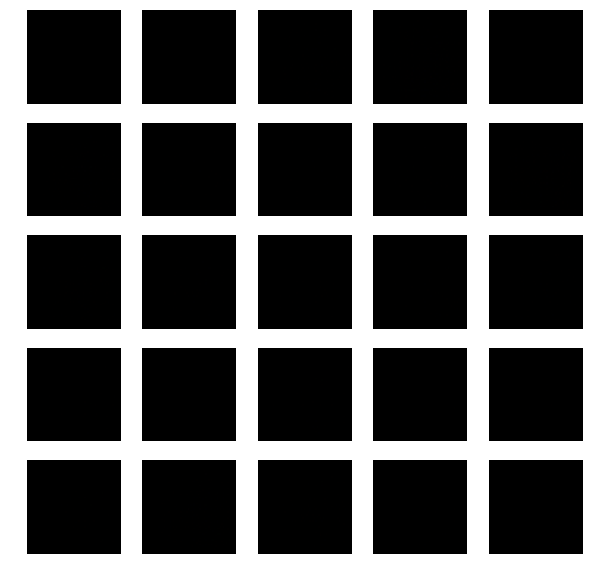

In [12]:
### TODO: Draw 25 samples from VAE here
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    z = np.random.normal(size=(1, latent_size))
    image = sess.run(decode, feed_dict={latent_placeholder : z})[0] ### YOUR CODE HERE
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that you want to generate an image of Brad Pitt. You start with a small number of random samples, say 5, and rank them according to their similarity to your vision of Brad Pitt: 1 for the worst, 5 for the best. You then rate image by image using GPyOpt that works in a latent space of VAE. For the new image, you need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). A user then enters score to a current image.

The proposed scoring has a lot of drawbacks, and you may feel free to come up with new ones: e.g. showing user 9 different images and asking a user which image looks the "best".

Note that the goal of this task is for you to implement a new algorithm by yourself. You may try different techniques for your task and select one that works the best.

<b>Task 2:</b> Implement person search using Bayesian optimization. (You can use code from the assignment on Gaussian Processes)

Note: try varying `acquisition_type` and `acquisition_par` parameters.

In [0]:
class FacialComposit:
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
        self.decode = decoder(self.latent_placeholder)
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
        img = sess.run(self.decode, 
                       feed_dict={self.latent_placeholder: latent[None, :]})[0]
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        clear_output()
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    @staticmethod
    def _draw_border(image, w=2):
        bordred_image = image.copy()
        bordred_image[:, :w] = [1, 0, 0]
        bordred_image[:, -w:] = [1, 0, 0]
        bordred_image[:w, :] = [1, 0, 0]
        bordred_image[-w:, :] = [1, 0, 0]
        return bordred_image

    def query_initial(self, n_start=5, select_top=None):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep
        '''
        
        samples = np.random.normal(size=(n_start,self.latent_size))
        images = np.array([self._get_image(samples[i]) for i in range(n_start)])
        
        # Show images
        self._show_images(images, range(n_start))
        print('1 - INITIAL POINTS FOR BAYESIAN OPTIMIZATION')
        print('Give maximum score to the best image and minimum to the worst (from 0 to 10, 0 being the worst).\n')
        print('Ex. : "Rating for IMAGE 0 : 10" ')
        
        # Code to select select_top images and rank them from 1 to 5
        chosen_idx, rating = [], []
        for i in range(select_top):
            #print('IMAGE INDEX' + str(i+1) + '/' + str(select_top))
            idx = i
            chosen_idx.append(int(float(idx)))
            rating_x = input('Rating for IMAGE ' + str(i)+ '  :  ')#+'/'+str(select_top)+ ': '
            rating.append(int(float(rating_x)))
        #print(chosen_idx)
        
        # Now select images and ratings
        
        self.samples = np.array(samples[chosen_idx]) ### YOUR CODE HERE (size: select_top x 64 x 64 x 3)
        self.images = np.array(images[chosen_idx]) ### YOUR CODE HERE (size: select_top x 64 x 64 x 3)
        self.rating = np.array(rating) ### YOUR CODE HERE (size: select_top)
        
        ### YOUR CODE:
        ### Show user some samples (hint: use self._get_image and input())

        # Check that tensor sizes are correct
        np.testing.assert_equal(self.rating.shape, [select_top])
        np.testing.assert_equal(self.images.shape, [select_top, 64, 64, 3])
        np.testing.assert_equal(self.samples.shape, [select_top, self.latent_size])

    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        '''
        initial_size = len(self.images)
        candidate_image = self._get_image(candidate[0]).reshape((1, 64, 64, 3))
        
        init_images_rank = np.argsort(self.rating)[::-1]
        init_images_to_display_idx = np.array([init_images_rank[0], init_images_rank[-1]])
        init_images_to_display = self.images[init_images_to_display_idx]
        ratings_to_display = init_images_rank[init_images_to_display_idx]
        #print(init_images_to_display.shape)
        #print(candidate_image.shape)
        
        comparaison = np.append(init_images_to_display, candidate_image, axis=0)
        
        #print(comparaison.shape)
        #print(comparaison) 
        
        self._show_images(comparaison, ['EXISTING BEST', 'EXISTING WORST', 'CANDIDATE'])
        #self.draw_best('CURRENT BEST')
                          
        print('2 - BAYESIAN OPTIMIZATION')
        print('Assign rating to candidate images (there will be 10 of them) based on previously shown images.')
        #print('Current best: '+str(ratings_to_display[0])+'/10')
        ### YOUR CODE HERE
        ## Show user an image and ask to assign score to it.
        ## You may want to show some images to user along with their scores
        ## You should also save candidate, corresponding image and rating
        
        candidate_rating = int(input('Does the candidate image match our objective? Assign rating to candidate: '))### YOUR CODE HERE
        
        #print(self.rating.shape)
        self.images = np.append(self.images, candidate_image, axis=0)
        self.rating = np.append(self.rating, candidate_rating)                                
        self.samples = np.append(self.samples, candidate, axis=0)
        
        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating

    def optimize(self, n_iter=10, w=4, acquisition_type='MPI', acquisition_par=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argmax(self.rating)
        image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

#### GRADED 2 (3 points):
Describe your approach below: How do you assign a score to a new image? How do you select reference images to help user assign a new score? What are the limitations of your approach?

**bold text**> Your answer here

## Testing your algorithm

In these sections, we will apply the implemented app to search for different people. Each task will ask you to generate images that will have some property like "dark hair" or "mustache". You will need to run your search algorithm and provide the best discovered image.

#### Task 3.1: Finding person with darkest hair (3 points)

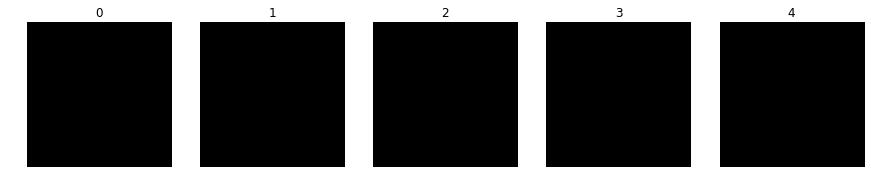

1 - INITIAL POINTS FOR BAYESIAN OPTIMIZATION
Give maximum score to the best image and minimum to the worst (from 0 to 10, 0 being the worst).

Ex. : "Rating for IMAGE 0 : 10" 


TypeError: ignored

In [15]:
composit = FacialComposit(decoder, 8)
composit.optimize()

In [17]:
composit.draw_best('Darkest hair')

TypeError: ignored

#### Task 3.2. Finding person with the widest smile (3 points)

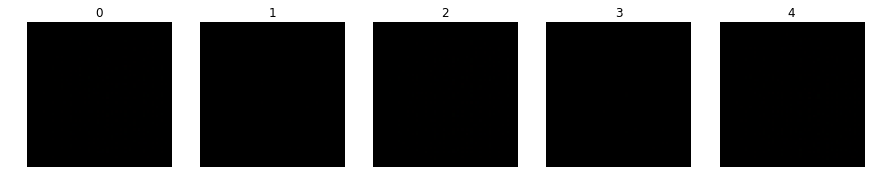

1 - INITIAL POINTS FOR BAYESIAN OPTIMIZATION
Give maximum score to the best image and minimum to the worst (from 0 to 10, 0 being the worst).

Ex. : "Rating for IMAGE 0 : 10" 


TypeError: ignored

In [18]:
composit = FacialComposit(decoder, 8)
composit.optimize()

In [19]:
composit.draw_best('Widest smile')

TypeError: ignored

#### Task 3.3. Finding Daniil Polykovskiy or Alexander Novikov — lecturers of this course (3 points) 

Note: this task highly depends on the quality of a VAE and a search algorithm. You may need to restart your search algorithm a few times and start with larget initial set.

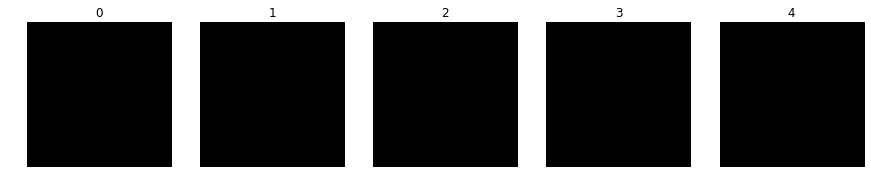

1 - INITIAL POINTS FOR BAYESIAN OPTIMIZATION
Give maximum score to the best image and minimum to the worst (from 0 to 10, 0 being the worst).

Ex. : "Rating for IMAGE 0 : 10" 


TypeError: ignored

In [20]:
composit = FacialComposit(decoder, 8)
composit.optimize()

In [21]:
composit.draw_best('Lecturer')

TypeError: ignored

#### <small>Don't forget to post resulting image of lecturers on the forum ;)</small>

#### Task 3.4. Finding specific person (optional, but very cool)

Now that you have a good sense of what your algorithm can do, here is an optional assignment for you. Think of a famous person and take look at his/her picture for a minute. Then use your app to create an image of the person you thought of. You can post it in the forum <a href="https://www.coursera.org/learn/bayesian-methods-in-machine-learning/discussions/forums/SE06u3rLEeeh0gq4yYKIVA">Final project: guess who!</a>


In [22]:
composit = FacialComposit(decoder, latent_size=8, nb_images_for_bayesopt=10)
composit.optimize()### Your code here

TypeError: ignored

### Submission
You need to share this notebook via a link: click `SHARE` (in the top-right corner) $\rightarrow$ `Get shareable link` and then paste the link into the assignment page.

**Note** that the reviewers always see the current version of the notebook, so please do not remove or change the contents of the notebook until the review is done.

##### If you are working locally (e.g. using Jupyter instead of Colab)
Please upload your notebook to Colab and share it via the link or upload the notebook to any file sharing service (e.g. Dropbox) and submit the link to the notebook through https://nbviewer.jupyter.org/, so by clicking on the link the reviewers will see it's contents (and will not need to download the file).

### Grading criterions

#### Task 1 (3 points) [samples from VAE]
* 0 points: No results were provided here or provided images were not generated by VAE
* 1 point: Provided images poorly resemble faces
* 2 points: Provided images look like faces, maybe with some artifacts, but all look the same
* 3 points: Provided images look like faces, maybe with some artifacts, and look different

#### Task 2 (3 points) [training procedure]
* 0 points: No result was provided
* 1 point: Some algorithm was proposed, but it does not use Bayesian optimization
* 2 points: Algorithm was proposed, but there were no details on some important aspects: how to assign a score to a new image / how to you select a new image / what are the limitations of the approach
* 3 points: Algorithm was proposed, all questions in the task were answered

#### Tasks 3.1-3.3 (3 points each) [search for person]
* 0 points: Nothing was provided
* 1 point: Resulting image was provided, but some of the required images (evolution & nearest image) are not provided
* 2 points: All images are provided, but the resulting image does not have requested property
* 3 points: All images are provided, the resulting image has required features (long hair / wide smile / looks like lecturer)

## Passing grade is 60% (9 points)